# Clustering Time Series with PCA and DBSCAN

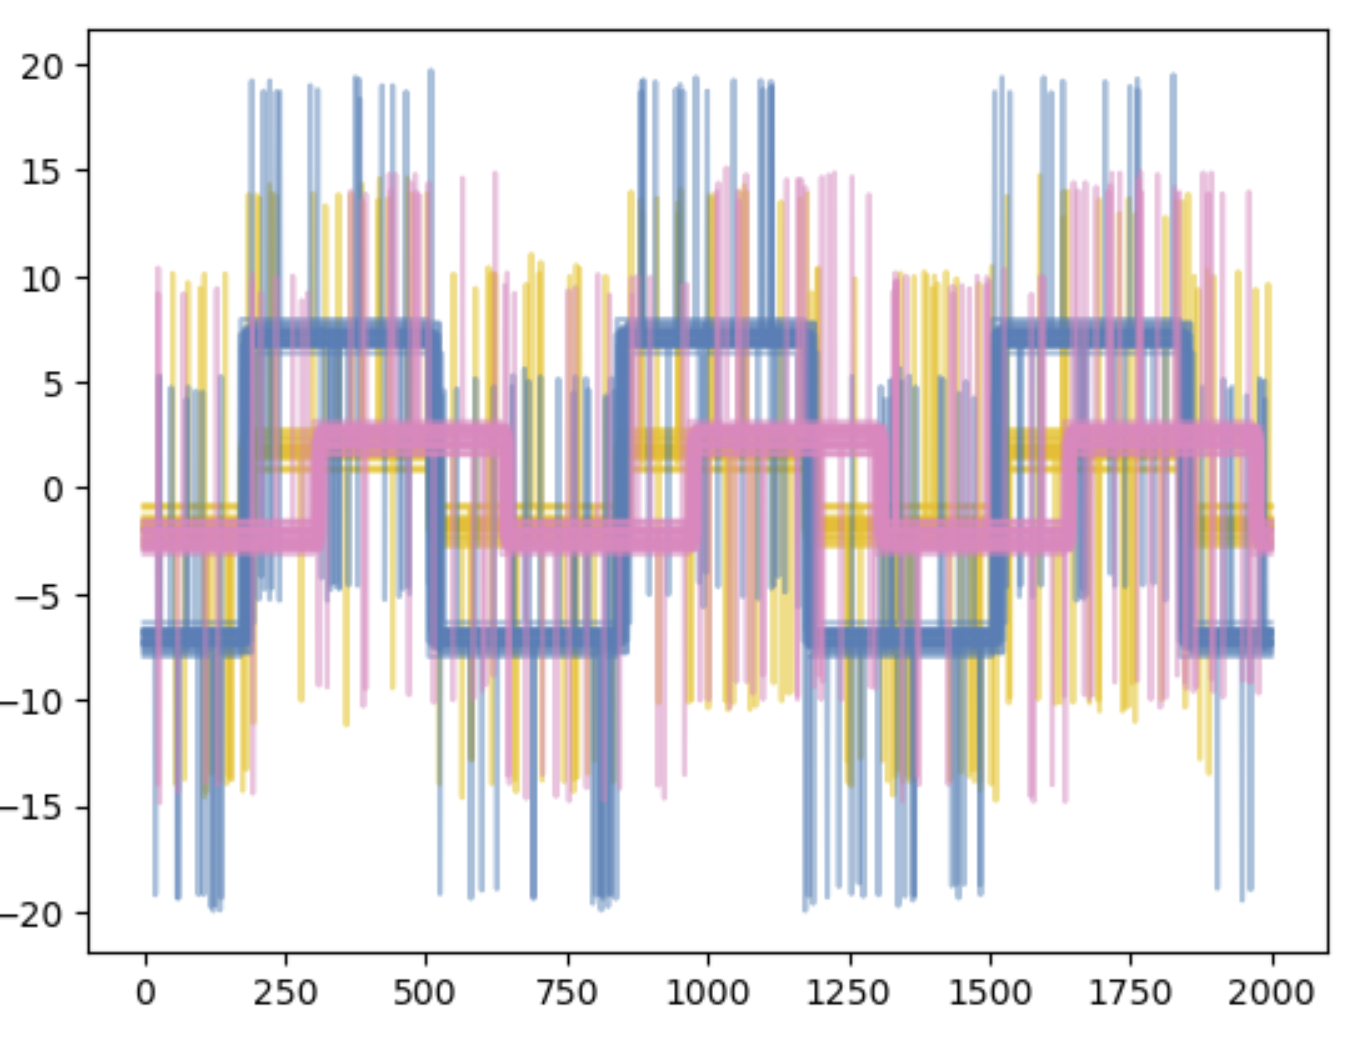

## Aknowledgement (for data generation portion):
- Author: Gael Varoquaux
- License: BSD 3-Clause or CC-0

Derived from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering_metrics.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-metrics-py

The graph above ther are three main clusters of patterns that each vary somewhat from other members in its own cluster and each cluster exhibits slighty diferent aggregate behavior from each other as well.

The goal of the exercise is to identify the common time series clusters and label them in an unsupervised way so that they can be colored by aggreagate membership in similar behaviors

## Background

Sometimes human behavior, repetetive machinery and other measurable sources exhibit repetitious behaviors.  Think of patterns of traffic on roads in city over the course of a month - the trafic flow patterns will begin to show wekday early morning, mid day, at end of work day patterns as well as patterns for weekends

It is not so easy to label these patterns until you get a sense of cluster of patterns themselves.

This is the task of unsupervised learning.

There are many methods people use: Dimensionality reduction, DBSCAN, KMeans, Pairwise distance, and more - all are emplementable in sklearn , and for most of these Intel proved accelerations through a library called the Intel Extension for Scikit-learn



Text(0.5, 1, 'Unlabeled Data')

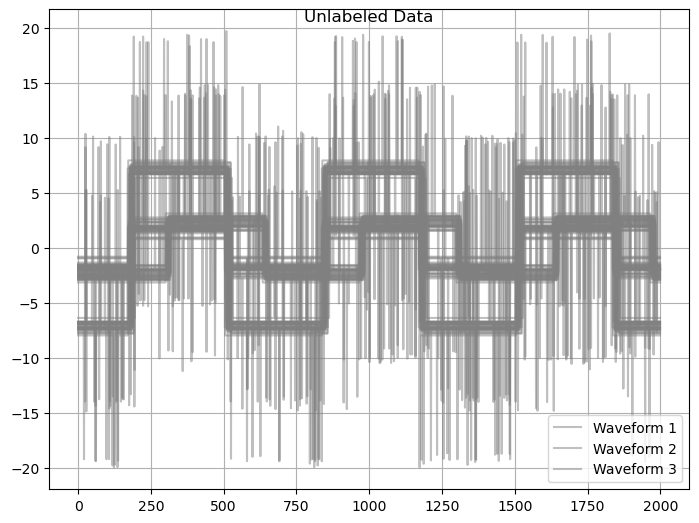

In [13]:
# Author: Gael Varoquaux
# License: BSD 3-Clause or CC-0

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))


X = list()
y = list()
for i, (phi, a) in enumerate([(0.5, 0.15), (0.5, 0.6), (0.3, 0.2)]):
    for _ in range(30):
        phase_noise = 0.01 * np.random.normal()
        amplitude_noise = 0.04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < 0.997] = 0

        X.append(
            12
            * (
                (a + amplitude_noise) * (sqr(6 * (t + phi + phase_noise)))
                + additional_noise
            )
        )
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ("Waveform 1", "Waveform 2", "Waveform 3")

colors = ["gray", "gray", "gray"]

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, color, n in zip(range(n_clusters), colors, labels):
    lines = plt.plot(X[y == l].T, c=color, alpha=0.5)
    lines[0].set_label(n)

plt.legend(loc="best")


plt.axis("tight")
plt.axis("on")
plt.grid()
plt.suptitle("Unlabeled Data", size=12, y=1)




# Dimensionality Reduction using PCA

Before we attempt clustering on 90 rows of data each containing 2000 samples, I will use Principal Component Analysis (PCA) to reduce the dimensions of the data while keepning 99 percent of the useful information in the dataset

```python
X.shape = (90,2000)
```

After PCA and exploring a good values to try for n_components, we arrive at a faithful facsimile of the reduced data set as compared to the original data

```python
XPC.shape = (90, 4)
```

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
XPC = pca.fit_transform(X) # XPC is reduced data version
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(XPC.shape)
df = pd.DataFrame(XPC)
df

[0.81845299 0.0706514  0.03222981 0.01287891]
[1229.84584833  361.33847283  244.05216215  154.27419253]
(90, 4)


,0,1,2,3
0,-43.138723,-55.188516,4.696792,14.928824
1,-50.216116,-33.904267,-30.153829,12.477473
2,-60.208884,-47.515361,-15.619536,-6.888023
3,-40.602349,-48.218534,-2.968849,-2.501236
4,-59.156595,-48.472627,-12.118236,-6.234494
...,...,...,...,...
85,-123.337566,54.145293,14.045076,1.071611
86,-124.744643,24.359045,6.151405,0.502043
87,-119.899881,25.079537,4.371837,0.354819
88,-129.314853,35.643524,9.527828,-1.135754


# Plot the PCA data in a Pairplot 

Look for visible clusters in each plot - this will identify which principal componets to to use to separate out our data

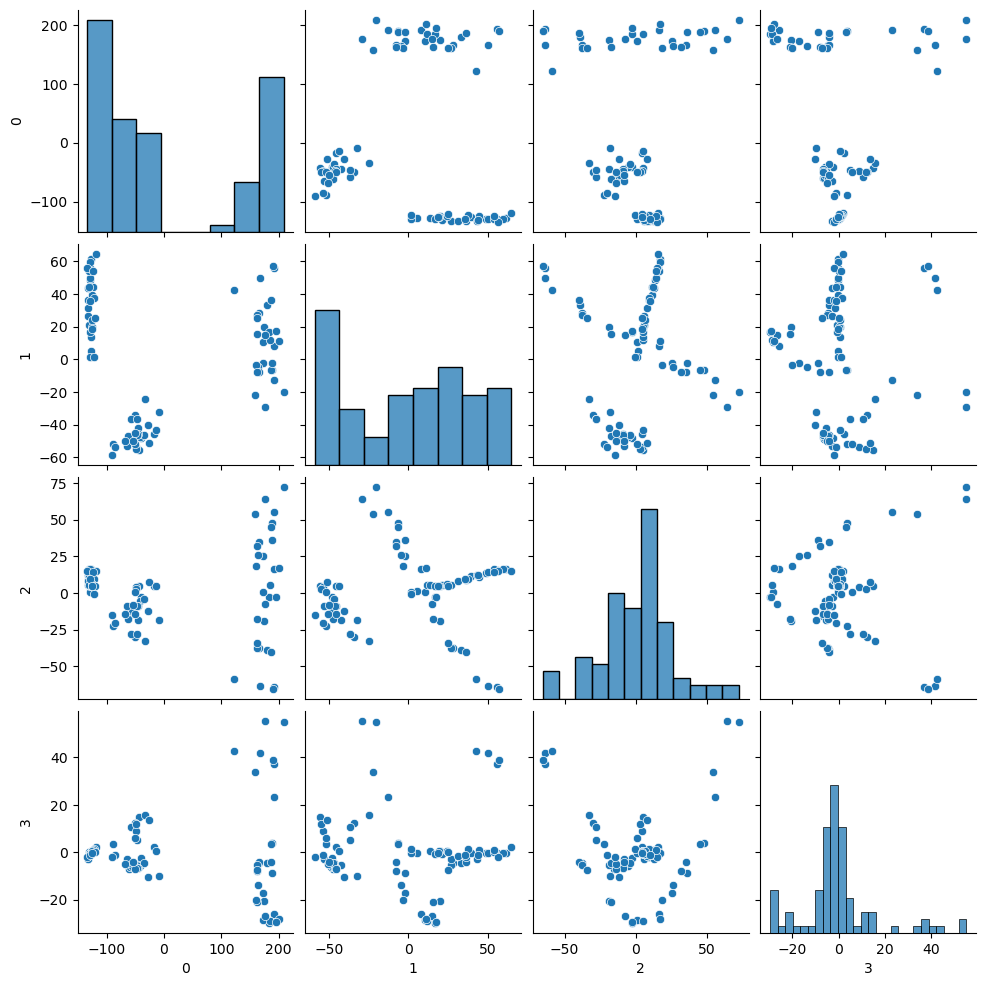

In [15]:
import seaborn as sns
sns.pairplot(df)


# Visaul Inspection to estimate a good epc for DBSCAN

Looking at the Pairplot, PC0 and PC1 seem to separate the clusters pretty well, and identifies three clear clusters

```python
clustering = DBSCAN(eps=50, min_samples=3).fit(XPC[:,[0,1]])
```

**eps** is the min distance we should use to indicate if points are more than eps away it identifies a different cluster

**min_samples** indicates how many points that are close together shoudl we identify as a cluster

**labels** is the variable I use to capture the cluster ID ( in this case 90 labels one for each sample (each containing a different time series0


In [16]:
from sklearn.cluster import DBSCAN
import numpy as np
start = time.time()
clustering = DBSCAN(eps=50, min_samples=3).fit(XPC[:,[0,1]])
# clustering.labels_
labels = clustering.fit_predict (XPC[:,[0,1]])
print(f"elapsed time {time.time() - start}")
print(labels)

elapsed time 0.002328634262084961
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Text(0.5, 1, 'PCA + DBSCAN')

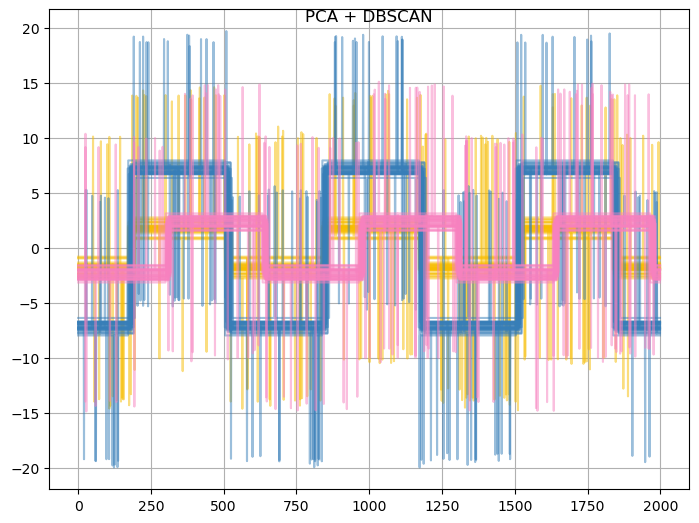

In [17]:
# Plot the ground-truth labelling

n_clusters = 3

colors = ["#f7bd01", "#377eb8", "#f781bf"]

plt.figure()
plt.axes([0, 0, 1, 1])
for l, color, n in zip(range(n_clusters), colors, labels):
    lines = plt.plot(X[y == l].T, c=color, alpha=0.5)
    lines[0].set_label(n)

plt.axis("tight")
plt.axis("on")
plt.grid()
plt.suptitle("PCA + DBSCAN", size=12, y=1)

# Compare to Ground Truth

Text(0.5, 1, 'Ground Truth')

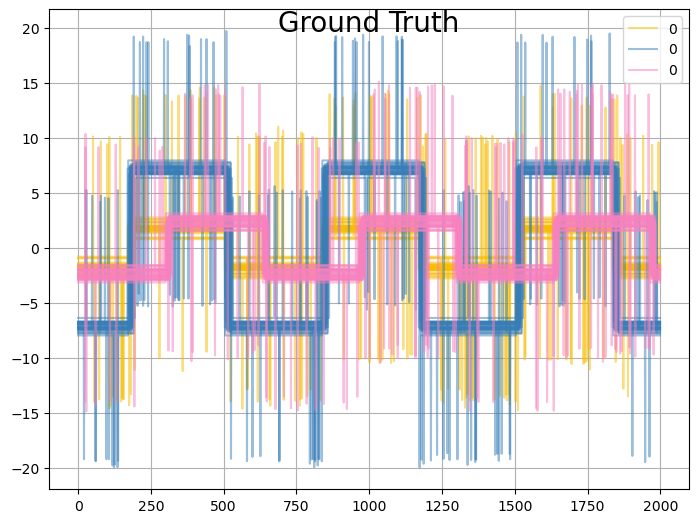

In [18]:
# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, color, n in zip(range(n_clusters), colors, labels):
    lines = plt.plot(X[y == l].T, c=color, alpha=0.5)
    lines[0].set_label(n)

plt.legend(loc="best")


plt.axis("tight")
plt.axis("on")
plt.grid()
plt.suptitle("Ground Truth", size=20, y=1)
